# Overview of Fast Gradient Sign Method (FGSM) as introduced in Goodfellow et al. 2015

In [ ]:
# insert FGSM equation here

In [62]:
import torch
import torchvision
import ast
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [3]:
IDX_TO_LABEL = 'data/imagenet/idx_to_label.txt'

## Load GoogLeNet Model

In [96]:
model = torchvision.models.googlenet(pretrained=True, transform_input=True)
_ = model.eval() # very important

## Load Index/Class Mappings

In [11]:
with open(IDX_TO_LABEL, 'r') as f:
    idx_to_label = ast.literal_eval(f.read())

label_to_idx = dict()
for k, v in idx_to_label.items():
    classes = v.split(', ')
    for c in classes:
        label_to_idx[c] = k

## Load images

In [40]:
import torchvision.transforms.functional as TF

def load_image(path):
    img = Image.open(path)
    img = TF.to_tensor(img)
    img = img.unsqueeze(0)
    return img

def show_img(img):
    img = img[0]
    img = img.permute(1,2,0)
    plt.imshow(img)

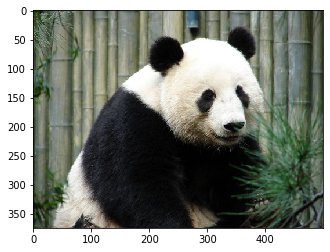

In [194]:
dog = load_image('data/imagenet/dog.jpg') # label = 'Eskimo dog, husky'
panda = load_image('data/imagenet/panda.jpg')
phone = load_image('data/imagenet/phone.jpg')
submarine = load_image('data/imagenet/submarine.jpg')
shark = load_image('data/imagenet/shark.jpg')

show_img(panda)

## Prediction Functions

In [216]:
class Prediction:
    def __init__(self, p, idx, label):
        self.p = p
        self.idx = idx
        self.label = label
        
    def __str__(self):
        return 'p: {}, idx: {}, label: {}'.format(self.p, self.idx, self.label)
    
def pred_proba(model, img, idx_to_label):
    # Return confidence, index, and class
    raw_pred = model(img)
    proba = F.softmax(raw_pred, dim=1)
    max_val = proba.max(1)
    idx = max_val.indices[0].item()
    proba = max_val.values[0].item()
    label = idx_to_label[idx]
    return (proba, idx, label)

## FGSM

In [147]:
def dj_dx(model, img, class_idx):
    img_copy = torch.Tensor(img)
    img_copy.requires_grad = True
    label = torch.LongTensor([class_idx])
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(model(img_copy), label)
    loss.backward()
    return img_copy.grad

In [153]:
def fgsm(model, img, class_idx, eps):
    grad = dj_dx(model, img, class_idx)
    nu = eps * torch.sign(grad)
    adv = img + nu
    return img, nu, adv

In [196]:
pred_proba(model, dog, idx_to_label)

torch.return_types.max(
values=tensor([0.0607], grad_fn=<MaxBackward0>),
indices=tensor([248]))


(0.06068041920661926, 248, 'Eskimo dog, husky')

In [210]:
img, nu, adv = fgsm(model, panda, label_to_idx['panda'], 0.01)

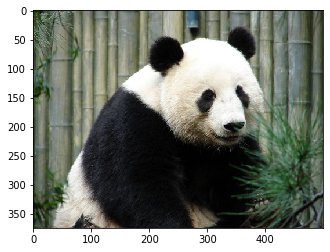

In [211]:
show_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


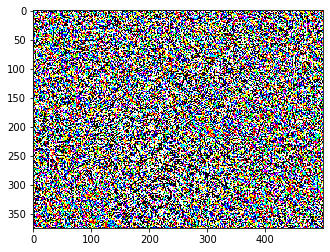

In [212]:
show_img(nu * 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


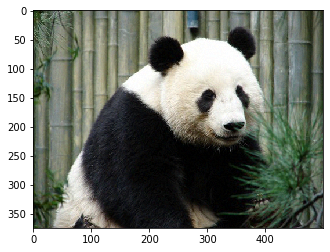

In [213]:
show_img(adv)

In [214]:
pred_proba(model, adv, idx_to_label)

torch.return_types.max(
values=tensor([0.0093], grad_fn=<MaxBackward0>),
indices=tensor([794]))


(0.009252944029867649, 794, 'shower curtain')

In [215]:
pred_proba(model, img, idx_to_label)

torch.return_types.max(
values=tensor([0.0468], grad_fn=<MaxBackward0>),
indices=tensor([388]))


(0.04675527662038803,
 388,
 'giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca')